<h1><b>Movie Recommendation System Using NLP, Hybrid Filtering, and Sentiment Analysis</b></h1>


In [3]:
import pandas as pd
import spacy
import random

import matplotlib.pyplot as plt
import seaborn as sns

from spacy import displacy

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split as sklearn_train_test_split  # Alias to avoid conflict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import numpy as np
import random

from surprise import Reader, Dataset, SVD, AlgoBase
import gc  # Import the garbage collector

import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install scikit-surprise

# **Load the dataset**

In [3]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

# **Read The dataset**

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


# **Dataset Description**

In [6]:
def info(dataset, name):
  print("Dataset Name: ", name)
  print(f"Number of Rows: {dataset.shape[0]}")
  print(f"Number of Columns: {dataset.shape[1]}")
  print(f"Number of observations: {dataset.shape[0]*dataset.shape[1]}")
  print("Datatypes of all variables:")
  dataset.info()

In [7]:
info(movies, 'movies')

Dataset Name:  movies
Number of Rows: 62423
Number of Columns: 3
Number of observations: 187269
Datatypes of all variables:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [8]:
info(ratings, 'ratings')

Dataset Name:  ratings
Number of Rows: 25000095
Number of Columns: 4
Number of observations: 100000380
Datatypes of all variables:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


# **Combination of the dataset**

In [9]:
combined_data = pd.merge(ratings, movies, on='movieId')

In [10]:
combined_data = combined_data.iloc[0:100000]

In [11]:
# model_data.to_csv("movies-and-ratings.csv", index = False)

In [12]:
info(combined_data, 'combined_data')

Dataset Name:  combined_data
Number of Rows: 100000
Number of Columns: 6
Number of observations: 600000
Datatypes of all variables:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100000 non-null  int64  
 1   movieId    100000 non-null  int64  
 2   rating     100000 non-null  float64
 3   timestamp  100000 non-null  int64  
 4   title      100000 non-null  object 
 5   genres     100000 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.3+ MB


In [13]:
combined_data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,3,296,5.0,1439474476,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2,4,296,4.0,1573938898,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,5,296,4.0,830786155,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
4,7,296,4.0,835444730,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


# **Check for null values in the combined dataset**

In [14]:
combined_data.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

# **Check data types of each column in the combined dataset**

In [15]:
combined_data.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
title         object
genres        object
dtype: object

# **Perform statistical analysis on the combined dataset**

In [18]:
combined_data.describe()

,userId,movieId,rating,timestamp
count,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,79114.723200,334.587720,4.157390,1.148640e+09
std,46791.340841,140.834929,0.959397,2.455927e+08
min,1.000000,296.000000,0.500000,8.256125e+08
25%,38608.750000,296.000000,4.000000,9.388627e+08
50%,77110.500000,296.000000,4.500000,1.127178e+09
75%,119505.500000,296.000000,5.000000,1.392872e+09
max,162541.000000,899.000000,5.000000,1.574313e+09


#**Movie Reccomendation Using NLP**

In [19]:
# Data dimension reduced due to reduce runtime and nullify the issues with system memory
model_data = combined_data.iloc[65000:65010]

In [20]:
# Defining sentiment-based categories by ratings
def categorize_sentiment(rating):
    if rating >= 4.0:
        return 'positive'
    elif rating <= 2.0:
        return 'negative'
    else:
        return 'neutral'

In [21]:
# Applying sentiment categorization to ratings
ratings['sentiment'] = ratings['rating'].apply(categorize_sentiment)

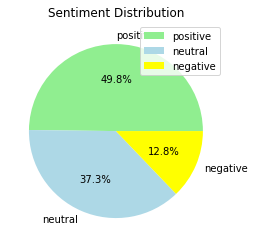

In [22]:
labels = ['positive', 'neutral', 'negative']
sizes = ratings['sentiment'].value_counts()
colors = ['lightgreen', 'lightblue', 'yellow']

plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors = colors)
plt.gca().set_title('Sentiment Distribution')
plt.gca().legend(loc='upper right', labels=labels)
plt.gca().set_aspect('equal')

plt.show()

In [23]:
# Function to train the RandomForestClassifier in batches
def train_classifier_in_batches(data, batch_size=10000):
    classifier = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)  # Smaller model for memory efficiency
    for start in range(0, data.shape[0], batch_size):
        end = start + batch_size
        batch_data = data.iloc[start:end]
        classifier.fit(batch_data[['userId', 'movieId']], batch_data['sentiment'])
    return classifier

In [24]:
# Split the data for sentiment analysis
train_data = ratings[['userId', 'movieId', 'sentiment']]

# Train the classifier in batches
classifier = train_classifier_in_batches(train_data)

In [25]:
# Delete training data and suggest garbage collection
del train_data
gc.collect()

3571

In [26]:
# Loading Surprise dataset for collaborative filtering
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Training the collaborative filtering model using SVD
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

In [6]:
def hybrid_recommendation_with_sentiment(user_id, title, n=10):
    # Ensure 'movies', 'classifier', and 'algo' are accessible here
    # Predicting sentiment for a target movie
    target_movie_id = movies[movies['title'] == title]['movieId'].iloc[0]
    predicted_sentiment = classifier.predict([[user_id, target_movie_id]])[0]
    
    # Obtaining recommendations using the collaborative filtering mechanism
    cf_recommendations = algo.test([(user_id, target_movie_id, 4.0)])

    # Adjusting scores based on sentiment
    adjusted_scores = []
    for prediction in cf_recommendations:
        # Accessing the estimated score
        score = prediction.est
        # Adjusting the score based on sentiment
        if predicted_sentiment == 'positive':
            score += 0.1
        elif predicted_sentiment == 'negative':
            score -= 0.1
        adjusted_scores.append((prediction.iid, score))

    # Sorting and returning top recommendations to the calling block
    adjusted_scores.sort(key=lambda x: x[1], reverse=True)
    top_recommendations = [(movies[movies['movieId'] == int(movie_id)]['title'].iloc[0], score) for movie_id, score in adjusted_scores[:n]]
    return top_recommendations


In [7]:
def svd_recommendations(user_id, movies, algo, n=10):
    """
    Generate recommendations using the SVD collaborative filtering model.

    Parameters:
    - user_id: The ID of the user for whom recommendations are to be made.
    - movies: DataFrame containing movie titles and IDs.
    - algo: Trained SVD collaborative filtering model.
    - n: Number of top recommendations to return.

    Returns:
    - top_recommendations: A list of top 'n' recommended movie titles based on SVD predictions.
    """
    # List to store each movie's predicted rating
    predictions = []

    # Iterate through all movie IDs in the movies DataFrame
    for movie_id in movies['movieId'].unique():
        # Predict the rating for the current user and movie
        prediction = algo.predict(uid=str(user_id), iid=str(movie_id))
        predictions.append((movie_id, prediction.est))

    # Sort the predictions based on the estimated rating
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Get the top 'n' movie IDs with the highest estimated ratings
    top_movie_ids = [movie_id for movie_id, _ in predictions[:n]]

    # Find corresponding movie titles
    top_recommendations = [(movies[movies['movieId'] == movie_id]['title'].iloc[0], score) for movie_id, score in predictions[:n]]

    return top_recommendations

In [8]:
# Example usage
user_id = random.randint(65001, 65011)  # Random user ID for demonstration
top_svd_recommendations = svd_recommendations(user_id, movies, algo, n=10)

print("Top recommendations based on SVD:")
for movie_title, estimated_rating in top_svd_recommendations:
    print(f"Movie Title: {movie_title}, Estimated Rating: {estimated_rating}")




NameError: name 'movies' is not defined

In [9]:
# Hybrid Recommendations Function
def hybrid_recommendation_with_sentiment(user_id, movies, algo, classifier, n=10):
    svd_predictions = []
    for movie_id in movies['movieId'].unique():
        prediction = algo.predict(uid=str(user_id), iid=str(movie_id))
        svd_predictions.append((movie_id, prediction.est))
    svd_predictions.sort(key=lambda x: x[1], reverse=True)
    top_svd_movie_ids = [movie_id for movie_id, _ in svd_predictions[:n]]

    adjusted_scores = []
    for movie_id in top_svd_movie_ids:
        predicted_sentiment = classifier.predict([[user_id, movie_id]])[0]
        original_score = next(score for mid, score in svd_predictions if mid == movie_id)
        adjusted_score = original_score + 0.1 if predicted_sentiment == 'positive' else original_score - 0.1
        adjusted_scores.append((movie_id, adjusted_score))

    adjusted_scores.sort(key=lambda x: x[1], reverse=True)
    top_recommendations = [(movies[movies['movieId'] == movie_id]['title'].iloc[0], score) for movie_id, score in adjusted_scores[:n]]
    return top_recommendations

In [10]:
# Example usage
user_id = random.randint(65001, 65011)  # Random user ID for demonstration

# SVD Recommendations
top_svd_recommendations = svd_recommendations(user_id, movies, algo, n=10)
print("Top recommendations based on SVD:")
for movie_title, estimated_rating in top_svd_recommendations:
    print(f"Movie Title: {movie_title}, Estimated Rating: {estimated_rating}")

NameError: name 'movies' is not defined

In [11]:
# Hybrid Recommendations
top_hybrid_recommendations = hybrid_recommendation_with_sentiment(user_id, movies, algo, classifier, n=10)
print("\nTop recommendations based on Hybrid model with sentiment adjustment:")
for movie_title, score in top_hybrid_recommendations:
    print(f"Movie Title: {movie_title}, Score: {score}")

NameError: name 'movies' is not defined

## Content-Based FIltering alogn with NLP NER imposition impacts

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Example: movies['genres'] = ['Action|Adventure', 'Comedy|Drama', ...]

# Convert genres to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b')  # Adjust token pattern to consider single letters (e.g., 'A')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies['genres'])


In [49]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [51]:
def content_based_recommendations_genres(movie_index, cosine_sim, n=10):
    sim_scores = list(enumerate(cosine_sim[movie_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]  # Exclude self
    movie_indices = [i[0] for i in sim_scores]
    return movies.iloc[movie_indices][['title', 'genres']]


In [53]:
movie_index = 0  # Index of a sample movie

# Recommendations based on genres
genre_recommendations = content_based_recommendations_genres(movie_index, cosine_sim)
print("Recommendations based on genres:")
print(genre_recommendations)

Recommendations based on genres:
                                                   title  \
2203                                         Antz (1998)   
3021                                  Toy Story 2 (1999)   
3653      Adventures of Rocky and Bullwinkle, The (2000)   
3912                    Emperor's New Groove, The (2000)   
4780                               Monsters, Inc. (2001)   
9949   DuckTales: The Movie - Treasure of the Lost La...   
10773                                   Wild, The (2006)   
11604                             Shrek the Third (2007)   
12969                     Tale of Despereaux, The (2008)   
17431  Asterix and the Vikings (Astérix et les Viking...   

                                            genres  
2203   Adventure|Animation|Children|Comedy|Fantasy  
3021   Adventure|Animation|Children|Comedy|Fantasy  
3653   Adventure|Animation|Children|Comedy|Fantasy  
3912   Adventure|Animation|Children|Comedy|Fantasy  
4780   Adventure|Animation|Children|Comed

In [54]:
# Create a copy of the original 'movies' DataFrame for NER processing
temp_movies = movies.copy()


In [55]:
import spacy

# Load the English language model from SpaCy
nlp = spacy.load('en_core_web_sm')

# Function to extract named entities from a title
def extract_named_entities(title):
    doc = nlp(title)
    return ' '.join([ent.text for ent in doc.ents])

# Apply the function to each movie title in the temporary dataset
temp_movies['title_entities'] = temp_movies['title'].apply(extract_named_entities)


In [56]:
temp_movies.head(10)

,movieId,title,genres,title_entities
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji 1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men 1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,
5,6,Heat (1995),Action|Crime|Thriller,1995
6,7,Sabrina (1995),Comedy|Romance,Sabrina 1995
7,8,Tom and Huck (1995),Adventure|Children,Tom Huck 1995
8,9,Sudden Death (1995),Action,Sudden Death
9,10,GoldenEye (1995),Action|Adventure|Thriller,GoldenEye 1995


In [57]:
tfidf_vectorizer_entities = TfidfVectorizer()
tfidf_matrix_entities = tfidf_vectorizer_entities.fit_transform(temp_movies['title_entities'])


In [58]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_entities = cosine_similarity(tfidf_matrix_entities, tfidf_matrix_entities)


In [59]:
def content_based_recommendations_entities(movie_index, cosine_sim, n=10):
    sim_scores = list(enumerate(cosine_sim[movie_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]  # Exclude self
    movie_indices = [i[0] for i in sim_scores]
    return temp_movies.iloc[movie_indices][['title', 'title_entities']]


In [60]:
movie_index = 0  # Index of a sample movie from the original 'movies' DataFrame

# Recommendations based on NER (using the temporary dataset)
ner_recommendations = content_based_recommendations_entities(movie_index, cosine_sim_entities)
print("Recommendations based on NER extracted from titles:")
print(ner_recommendations)

Recommendations based on NER extracted from titles:
                                         title        title_entities
24064        Toy Story That Time Forgot (2014)        Toy Story 2014
22634        Toy Story Toons: Small Fry (2011)       Toy Story Toons
24062  Toy Story Toons: Partysaurus Rex (2012)  Toy Story Toons 2012
33603                       Toy Masters (2014)      Toy Masters 2014
40614                       The Toy Box (1971)      The Toy Box 1971
24693                      The Toy Wife (1938)     The Toy Wife 1938
3                     Waiting to Exhale (1995)                  1995
5                                  Heat (1995)                  1995
15                               Casino (1995)                  1995
19                          Money Train (1995)                  1995


In [70]:
def weighted_combined_recommendations(movie_index, cosine_sim_genres, cosine_sim_ner, movies, temp_movies, weight_genre=0.8, weight_ner=0.2, n=10):
    # Genre-based recommendations
    genre_indices = content_based_recommendations_genres(movie_index, cosine_sim_genres, n*2).index  # Get more recommendations to filter later
    
    # NER-based recommendations
    ner_indices = content_based_recommendations_genres(movie_index, cosine_sim_ner, n).index
    
    # Initialize dictionary to keep track of scores
    combined_scores = {}
    
    # Assign scores based on genre similarity
    for idx in genre_indices:
        combined_scores[idx] = combined_scores.get(idx, 0) + weight_genre
    
    # Update scores based on NER similarity
    for idx in ner_indices:
        if idx in combined_scores:
            # If the movie is already recommended by genre, enhance its score
            combined_scores[idx] += weight_ner
        else:
            # If not, add it with the NER weight
            combined_scores[idx] = weight_ner
    
    # Sort movies by combined score
    sorted_scores = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Select top n movies
    top_indices = [idx for idx, score in sorted_scores[:n]]
    
    # Fetch top movies from the original movies DataFrame
    top_movies = movies.loc[top_indices]
    
    return top_movies[['title', 'genres']]


In [71]:
movie_index = 0  # Index of a sample movie from the original 'movies' DataFrame

# Generate weighted combined recommendations
weighted_recommendations = weighted_combined_recommendations(movie_index, cosine_sim, cosine_sim_entities, movies, temp_movies, n=10)
print("Weighted combined recommendations (80% genre, 20% NER):")
for index, row in weighted_recommendations.iterrows():
    print(f"{row['title']} - Genres: {row['genres']}")


Weighted combined recommendations (80% genre, 20% NER):
Toy Story Toons: Small Fry (2011) - Genres: Adventure|Animation|Children|Comedy|Fantasy
Antz (1998) - Genres: Adventure|Animation|Children|Comedy|Fantasy
Toy Story 2 (1999) - Genres: Adventure|Animation|Children|Comedy|Fantasy
Adventures of Rocky and Bullwinkle, The (2000) - Genres: Adventure|Animation|Children|Comedy|Fantasy
Emperor's New Groove, The (2000) - Genres: Adventure|Animation|Children|Comedy|Fantasy
Monsters, Inc. (2001) - Genres: Adventure|Animation|Children|Comedy|Fantasy
DuckTales: The Movie - Treasure of the Lost Lamp (1990) - Genres: Adventure|Animation|Children|Comedy|Fantasy
Wild, The (2006) - Genres: Adventure|Animation|Children|Comedy|Fantasy
Shrek the Third (2007) - Genres: Adventure|Animation|Children|Comedy|Fantasy
Tale of Despereaux, The (2008) - Genres: Adventure|Animation|Children|Comedy|Fantasy


In [80]:
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [81]:
# Function to get recommendations based on cosine similarity for Content-based filtering
def get_recommendations(movie_idx, cosine_sim_matrix, n=10):
    sim_scores = list(enumerate(cosine_sim_matrix[movie_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    movie_indices = [i[0] for i in sim_scores[1:n+1]]
    return movies.iloc[movie_indices]

# Final hybrid recommendation function with weighted collab filtering ,content-based filtering including NLP.
def final_hybrid_recommendation(user_id, movie_idx, n=10):
    # Get top-n genre-based recommendations
    genre_recs = get_recommendations(movie_idx, cosine_sim, n)
    
    # Get top-n entity-based recommendations
    entity_recs = get_recommendations(movie_idx, cosine_sim_entities, n)

    # Combine and deduplicate recommendations
    combined_recs = pd.concat([genre_recs, entity_recs]).drop_duplicates().head(n)
    
    # Adjust scores based on sentiment analysis and collaborative filtering
    final_scores = []
    for _, row in combined_recs.iterrows():
        # SVD prediction for collaborative filtering score
        svd_pred = algo.predict(uid=user_id, iid=row['movieId']).est
        
        # Sentiment analysis adjustment
        sentiment_pred = classifier.predict([[user_id, row['movieId']]])[0]
        sentiment_adjustment = 0.1 if sentiment_pred == 'positive' else -0.1 if sentiment_pred == 'negative' else 0
        
        final_score = svd_pred + sentiment_adjustment
        final_scores.append((row['title'], final_score))
    
    # Sort recommendations by final score
    final_scores.sort(key=lambda x: x[1], reverse=True)
    
    return final_scores[:n]



In [82]:
user_id = random.randint(65001, 65011)  # Example user ID
movie_idx = 0  # Toy Story

final_recommendations = final_hybrid_recommendation(user_id, movie_idx, 10)
print("Final Hybrid Recommendations:")
for title, score in final_recommendations:
    print(f"{title}: {score}")


Final Hybrid Recommendations:
Monsters, Inc. (2001): 3.8490598730383416
Emperor's New Groove, The (2000): 3.842089797777435
Toy Story 2 (1999): 3.590477492695138
DuckTales: The Movie - Treasure of the Lost Lamp (1990): 3.451761818761212
Asterix and the Vikings (Astérix et les Vikings) (2006): 3.3886823408906324
Antz (1998): 3.2028772294426804
Shrek the Third (2007): 3.1377783819259
Wild, The (2006): 2.8436908149432374
Tale of Despereaux, The (2008): 2.804102244599292
Adventures of Rocky and Bullwinkle, The (2000): 2.4761165179099045


In [93]:
# Function to compile recommendation results to Pandas dataframe
def compile_recommendation_results(user_id, movie_idx, movies, algo, classifier, n=10):
    # Initialize DataFrame to store results
    results_df = pd.DataFrame(columns=['SVD', 'SVD_Sentiment', 'Genre_Based', 'NER_Based', 'Weighted_Genre_NER', 'Final_Hybrid'])

    # SVD Recommendations
    svd_recs = svd_recommendations(user_id, movies, algo, n)
    results_df['SVD'] = [title for title, _ in svd_recs]

    # SVD with Sentiment Adjustments
    svd_sentiment_recs = hybrid_recommendation_with_sentiment(user_id, movies, algo, classifier, n=10)
    results_df['SVD_Sentiment'] = [title for title, _ in svd_sentiment_recs]

    # Genre-Based Recommendations
    genre_recs = get_recommendations(movie_idx, cosine_sim, n)
    results_df['Genre_Based'] = genre_recs['title'].values

    # NER-Based Recommendations
    ner_recs = get_recommendations(movie_idx, cosine_sim_entities, n)
    results_df['NER_Based'] = ner_recs['title'].values

    # Weighted Genre + NER Recommendations
    weighted_genre_ner_recs = weighted_combined_recommendations(movie_idx, cosine_sim, cosine_sim_entities, movies, temp_movies, n=n)
    results_df['Weighted_Genre_NER'] = weighted_genre_ner_recs['title'].values

    # Final Hybrid Recommendations
    final_hybrid_recs = final_hybrid_recommendation(user_id, movie_idx, 10)
    results_df['Final_Hybrid'] = [title for title, _ in final_hybrid_recs]

    return results_df


In [94]:

# Example usage
user_id = random.randint(65001, 65011)  # Example user ID for demonstration
movie_idx = 0  # Index for "Toy Story" in the movies DataFrame

# Generate and compile the recommendation results
recommendation_results = compile_recommendation_results(user_id, movie_idx, movies, algo, classifier, n=10)
print(recommendation_results)


                                  SVD                       SVD_Sentiment  \
0                    Toy Story (1995)                    Toy Story (1995)   
1                      Jumanji (1995)                      Jumanji (1995)   
2             Grumpier Old Men (1995)             Grumpier Old Men (1995)   
3            Waiting to Exhale (1995)            Waiting to Exhale (1995)   
4  Father of the Bride Part II (1995)  Father of the Bride Part II (1995)   
5                         Heat (1995)                         Heat (1995)   
6                      Sabrina (1995)                      Sabrina (1995)   
7                 Tom and Huck (1995)                 Tom and Huck (1995)   
8                 Sudden Death (1995)                 Sudden Death (1995)   
9                    GoldenEye (1995)                    GoldenEye (1995)   

                                         Genre_Based  \
0                                        Antz (1998)   
1                                 Toy St

In [96]:
recommendation_results.head(10)

,SVD,SVD_Sentiment,Genre_Based,NER_Based,Weighted_Genre_NER,Final_Hybrid
0,Toy Story (1995),Toy Story (1995),Antz (1998),Toy Story That Time Forgot (2014),Toy Story Toons: Small Fry (2011),"Monsters, Inc. (2001)"
1,Jumanji (1995),Jumanji (1995),Toy Story 2 (1999),Toy Story Toons: Small Fry (2011),Antz (1998),Toy Story 2 (1999)
2,Grumpier Old Men (1995),Grumpier Old Men (1995),"Adventures of Rocky and Bullwinkle, The (2000)",Toy Story Toons: Partysaurus Rex (2012),Toy Story 2 (1999),"Emperor's New Groove, The (2000)"
3,Waiting to Exhale (1995),Waiting to Exhale (1995),"Emperor's New Groove, The (2000)",Toy Masters (2014),"Adventures of Rocky and Bullwinkle, The (2000)",Antz (1998)
4,Father of the Bride Part II (1995),Father of the Bride Part II (1995),"Monsters, Inc. (2001)",The Toy Box (1971),"Emperor's New Groove, The (2000)",Asterix and the Vikings (Astérix et les Viking...
5,Heat (1995),Heat (1995),DuckTales: The Movie - Treasure of the Lost La...,The Toy Wife (1938),"Monsters, Inc. (2001)",Shrek the Third (2007)
6,Sabrina (1995),Sabrina (1995),"Wild, The (2006)",Waiting to Exhale (1995),DuckTales: The Movie - Treasure of the Lost La...,DuckTales: The Movie - Treasure of the Lost La...
7,Tom and Huck (1995),Tom and Huck (1995),Shrek the Third (2007),Heat (1995),"Wild, The (2006)","Tale of Despereaux, The (2008)"
8,Sudden Death (1995),Sudden Death (1995),"Tale of Despereaux, The (2008)",Casino (1995),Shrek the Third (2007),"Wild, The (2006)"
9,GoldenEye (1995),GoldenEye (1995),Asterix and the Vikings (Astérix et les Viking...,Money Train (1995),"Tale of Despereaux, The (2008)","Adventures of Rocky and Bullwinkle, The (2000)"


In [97]:
# Example usage
user_id = random.randint(65001, 65011)  # Example user ID for demonstration
movie_idx = 1321  # 

# Generate and compile the recommendation results
recommendation_results1 = compile_recommendation_results(user_id, movie_idx, movies, algo, classifier, n=10)
recommendation_results1.head(15)

,SVD,SVD_Sentiment,Genre_Based,NER_Based,Weighted_Genre_NER,Final_Hybrid
0,Toy Story (1995),Toy Story (1995),Independence Day (a.k.a. ID4) (1996),Star Trek: Renegades (2015),Independence Day (a.k.a. ID4) (1996),Star Trek: First Contact (1996)
1,Jumanji (1995),Jumanji (1995),Escape from L.A. (1996),Star Trek (2009),Escape from L.A. (1996),Star Trek II: The Wrath of Khan (1982)
2,Grumpier Old Men (1995),Grumpier Old Men (1995),"Abyss, The (1989)",Building Star Trek (2016),"Abyss, The (1989)","Abyss, The (1989)"
3,Waiting to Exhale (1995),Waiting to Exhale (1995),Escape from New York (1981),Star Trek: Generations (1994),Escape from New York (1981),Total Recall (1990)
4,Father of the Bride Part II (1995),Father of the Bride Part II (1995),Star Trek: First Contact (1996),Star Trek: Nemesis (2002),Star Trek: First Contact (1996),Moonraker (1979)
5,Heat (1995),Heat (1995),Star Trek II: The Wrath of Khan (1982),Star Trek: Insurrection (1998),Star Trek II: The Wrath of Khan (1982),Independence Day (a.k.a. ID4) (1996)
6,Sabrina (1995),Sabrina (1995),"Lost World: Jurassic Park, The (1997)",Star Trek Into Darkness (2013),"Lost World: Jurassic Park, The (1997)","Lost World: Jurassic Park, The (1997)"
7,Tom and Huck (1995),Tom and Huck (1995),Spawn (1997),Star Trek: The Motion Picture (1979),Spawn (1997),Escape from New York (1981)
8,Sudden Death (1995),Sudden Death (1995),Total Recall (1990),Star Trek: Of Gods and Men (2007),Total Recall (1990),Spawn (1997)
9,GoldenEye (1995),GoldenEye (1995),Moonraker (1979),Star Trek Beyond (2016),Moonraker (1979),Escape from L.A. (1996)


## EXPERIEMENTATON REFERENCES with CONTENT BASED & NLP NER

In [61]:
# Combine genres and named entities into a single feature set in temp_movies
temp_movies['combined_features'] = temp_movies['genres'] + ' ' + temp_movies['title_entities']


In [62]:
temp_movies.head(10)

,movieId,title,genres,title_entities,combined_features
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 1995,Adventure|Animation|Children|Comedy|Fantasy To...
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji 1995,Adventure|Children|Fantasy Jumanji 1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men 1995,Comedy|Romance Grumpier Old Men 1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,Comedy|Drama|Romance 1995
4,5,Father of the Bride Part II (1995),Comedy,,Comedy
5,6,Heat (1995),Action|Crime|Thriller,1995,Action|Crime|Thriller 1995
6,7,Sabrina (1995),Comedy|Romance,Sabrina 1995,Comedy|Romance Sabrina 1995
7,8,Tom and Huck (1995),Adventure|Children,Tom Huck 1995,Adventure|Children Tom Huck 1995
8,9,Sudden Death (1995),Action,Sudden Death,Action Sudden Death
9,10,GoldenEye (1995),Action|Adventure|Thriller,GoldenEye 1995,Action|Adventure|Thriller GoldenEye 1995


In [63]:
tfidf_vectorizer_combined = TfidfVectorizer(token_pattern='\\b\\w+\\b')
tfidf_matrix_combined = tfidf_vectorizer_combined.fit_transform(temp_movies['combined_features'])


In [65]:
from sklearn.decomposition import TruncatedSVD

In [66]:
# Reduce the dimensionality of the TF-IDF matrix
svd = TruncatedSVD(n_components=100)  # Adjust n_components based on your dataset and available memory
reduced_tfidf_matrix = svd.fit_transform(tfidf_matrix_combined)

In [67]:
def combined_content_based_recommendations(movie_index, reduced_tfidf_matrix, temp_movies, n=10):
    # Compute cosine similarity for the selected movie against all others, using the reduced feature set
    cosine_sim = cosine_similarity(reduced_tfidf_matrix[movie_index:movie_index+1], reduced_tfidf_matrix).flatten()
    
    # Get the indices of the top n similar movies
    top_indices = cosine_sim.argsort()[-n-1:-1][::-1]  # Skip the first one as it will be the movie itself
    
    # Return the top n most similar movies
    return temp_movies.iloc[top_indices][['title', 'genres', 'title_entities']]


In [68]:
movie_index = 0  # Example index of a movie from temp_movies

# Generate recommendations using the combined features with reduced dimensionality
combined_recommendations = combined_content_based_recommendations(movie_index, reduced_tfidf_matrix, temp_movies, n=10)
print("Recommendations using combined genre and NER features with reduced dimensionality:")
for index, row in combined_recommendations.iterrows():
    print(f"{row['title']} - Genres: {row['genres']}, Named Entities: {row['title_entities']}")


Recommendations using combined genre and NER features with reduced dimensionality:
Thief and the Cobbler, The (a.k.a. Arabian Knight) (1995) - Genres: Adventure|Animation|Comedy|Fantasy, Named Entities: Cobbler Arabian Knight 1995
The Wind in the Willows (1995) - Genres: Adventure|Animation|Children|Comedy, Named Entities: 1995
Jumanji (1995) - Genres: Adventure|Children|Fantasy, Named Entities: Jumanji 1995
Indian in the Cupboard, The (1995) - Genres: Adventure|Children|Fantasy, Named Entities: Indian Cupboard 1995
Balto (1995) - Genres: Adventure|Animation|Children, Named Entities: Balto 1995
Kid in King Arthur's Court, A (1995) - Genres: Adventure|Children|Comedy|Fantasy|Romance, Named Entities: Court 1995
Kids of the Round Table (1995) - Genres: Adventure|Children|Comedy|Fantasy, Named Entities: the Round Table 1995
Slayers: The Motion Picture (1995) - Genres: Adventure|Animation|Comedy|Fantasy, Named Entities: The Motion Picture 1995
Gordy (1995) - Genres: Children|Comedy|Fantasy,

In [69]:
# from sklearn.metrics.pairwise import cosine_similarity

# cosine_sim_combined = cosine_similarity(tfidf_matrix_combined, tfidf_matrix_combined)

In [ ]:
# def combined_content_based_recommendations(movie_index, cosine_sim, temp_movies, n=10):
#     sim_scores = list(enumerate(cosine_sim[movie_index]))
#     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#     sim_scores = sim_scores[1:n+1]  # Exclude self
#     movie_indices = [i[0] for i in sim_scores]
#     return temp_movies.iloc[movie_indices][['title', 'genres', 'title_entities']]


In [101]:
# # Cleanup to free memory after recommendations, if necessary
# gc.collect()


2356